# Complex Reactions in PBR & CSTR & semi-BR & BR

In [1]:
# ALWAYS START WITH THIS CODE...SUGGEST NOT TO CHANGE IT
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.integrate
import scipy.optimize

/Users/nickcraig/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/nickcraig/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Reactions
$$\require{mhchem}$$
$$\ce{A -> R-> S}\tag{Reaction 1}$$
$$\ce{R +S -> 2S}\tag{Reaction 2}$$


## Part (a)
A PBR with gas phase reactions will be simulated.  It is given that the reactions have elementary kinetics--a highly dubious assumption, but we proceed...

We are given reaction rates in terms of specific components:
\begin{align*}
-r'_{1A} &= k_{1A} C_A C_B^2\\
-r'_{2C} &= k_{2C} C_A^2 C_C^3\\
\end{align*}

We will use the following rate notation for the reactions:
\begin{align*}
r'_1 &= k_1 C_A C_B^2\\
r'_2 &= k_2 C_A^2 C_C^3\\
\end{align*}

Where
\begin{align*}
k_1 &= k_{1A}/1 &= 1.08x10^-3\\
k_2 &= k_{2R}/1\\
k_3 &= k_{2S}/2\\
\end{align*}

Our mole balances become
\begin{align*}
\frac{dF_A}{dW} &= - r_1 - 2r_2\\
\frac{dF_B}{dW} &= -2r_1 \\
\frac{dF_C}{dW} &= +r_1 -3 r_2\\
\frac{dF_D}{dW} &= +r_2
\end{align*}



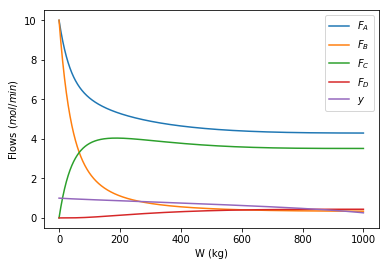

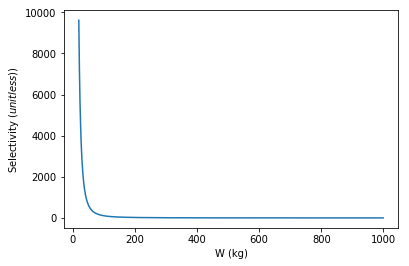

Maximum flow is 4 mol/dm3
It occurs at about 187 +/- 1 seconds


In [3]:
# Inlet conditions, as this template is PBR.  
# These would be "initial conditions" for BR/semiBR, where time varies instead.
Ct0 = 0.2 #M UNKNOWN
Ft0 = 20 # mol/min # UNKNOWN
Pa0 = 110 #kPa
T0 = 410 #C


# Note only four species in this template...you'd need more or less depending on actual scenario.
Fa0 = 0.5 * Ft0
Fb0 = 0.5 * Ft0
Fc0 = 0
Fd0 = 0

# This is PBR
alpha = 0.0019 # 1/kg
y0 = 1 # unitless pressure ratio

# REALLY IMPORTANT!!!  First copy k's referenced to species.
# Then: Convert k's from species reference to reaction number reference by dividing by stoichiometric coefficient.
k1A = 100 # L3/mol2/kgcat/min
k2C = 1500 # L5/mol4/kgcat/min

k1 = k1A/1
k2 = k2C/3


# The function block that follows defines all the differential equation forms.
def dFvectordW(Fvector, W):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Fa, Fb, Fc, Fd, y = Fvector # unpack values from vector into four flows and the y variable for PFR
    Ft = Fa + Fb + Fc + Fd # compute total flow

    # compute the concentrations that appear in rate expressions
    Ca = Ct0 * Fa / Ft * y
    Cb = Ct0 * Fb / Ft * y
    Cc = Ct0 * Fc / Ft * y

    # compute the rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3

    # compute the rates of generation of all species
    ra = -1 * r1 - 2 * r2
    rb = -2 * r1 + 0 * r2
    rc = +1 * r1 - 3 * r2
    rd = +0 * r1 + 1 * r2
    
    # Express the differential equations for rates of change of flows....
    # note you'd have additional terms for semi-BR or membrane PFR representing in/out flows
    dFadW = ra
    dFbdW = rb
    dFcdW = rc
    dFddW = rd

    # Differential equation for pressure drop ratio y.  This is just a PBR item.
    dydW = -alpha / (2 * y) * (Ft/Ft0)

    return [dFadW, dFbdW, dFcdW, dFddW, dydW] # pack up values into a vector.
    # "return" sends the info back to the ODE solver, many times

steps = np.linspace(0, 1000, num=1001) # steps for ODE integration.  Here W begins at 0 and goes to 1000, with "num" steps.

Fvector0 = [Fa0, Fb0, Fc0, Fd0, y0] # initial values as specified way up above

Y_result = scipy.integrate.odeint(dFvectordW, Fvector0, steps) # BOOM!  the ODE integration happens here!
# Note:  errors from this statement generally due to some incompatibility, like the vectors not the same length.

# extract columns by transposing matrix and splitting into variables (the template has 4 flows and "y")
Fa, Fb, Fc, Fd, y = Y_result.T 

# Do some plotting.  the plt.plot commands make the plots
plt.plot(steps, Fa, label='$F_A$')
plt.plot(steps, Fb, label='$F_B$')
plt.plot(steps, Fc, label='$F_C$')
plt.plot(steps, Fd, label='$F_D$')
plt.plot(steps, y, label='$y$')
# the next three lines format the plots with legend and axis labels.
plt.legend(loc="best")
plt.xlabel('W (kg)')
plt.ylabel('Flows ($mol/min$)')
plt.show()  # this displays the plot

# Look at selectivity too
plt.plot(steps[20:1000],Fc[20:1000]/Fd[20:1000])
#plt.plot(steps,Fc/Fd)
plt.legend(loc="best")
plt.xlabel('W (kg)')
plt.ylabel('Selectivity ($unitless$))')
plt.show()
#print(Fa[1000],Fb[1000],Fc[1000],Fd[1000],y[1000],Fc[1000]/Fd[1000]) #checking versus Fogler
# note vectors start at [0]



# this is just some code to locate a maximum and print some info
# first define the function for any array we call concentrations
# so that we can re-use it later
def report_max(concentrations, timesteps):
    max_R = concentrations.max()
    print ("Maximum flow is {0:.1g} mol/dm3".format(max_R))
    index = concentrations.argmax()
    max_time = timesteps[index]
    stepsize = timesteps[1]
    print ("It occurs at about {0:.0f} +/- {1:.0f} seconds".format(
                                                        max_time, stepsize))
# now call the function on the current Fc array
report_max(Fc, steps)

## Part (a--supplemental)
In assignment 6, we will be simulating varying temperature.
While it's perfectly fine to re-run the same block 3 times, there's nifty approaches to doing it all in one shot if you're interested.
Here's a code that would get the job done
We set it up with temperature as a variable in the first place, to avoid code repetition, here goes.
We can make some reusable functions

In [10]:
Ct100 = 0.2 #M
Ft0 = 20 # mol/min

Fa0 = 0.5 * Ft0
Fb0 = 0.5 * Ft0
Fc0 = 0
Fd0 = 0

alpha = 0.0019 # 1/kg
y0 = 1 # unitless pressure ratio

k1A = 100 # L3/mol2/kgcat/min
k2C = 1500 # L5/mol4/kgcat/min

k1 = k1A/1
k2 = k2C/3

def modify_k(k_at_100C, Ea, new_temperature_in_C):
    """
    This function takes the k at 100C, the activation 
    energy in kcal/mol, and a new temperature,
    and returns the k at that new temperature
    """
    R_kcal = 0.00198720413 # kcal/mol/K
    Tref = 100. + 273.15
    T = new_temperature_in_C + 273.15
    return k_at_100C * np.exp(-1*Ea/R_kcal * (1./T - 1./Tref))

def dFvectordW(Fvector, W, T_in_C, Ct0):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Fa, Fb, Fc, Fd, y = Fvector # unpack values from vector into four variables
    Ft = Fa + Fb + Fc + Fd
    # concentrations that appear in rates
    Ca = Ct0 * Fa / Ft * y
    Cb = Ct0 * Fb / Ft * y
    Cc = Ct0 * Fc / Ft * y

    # define the k1, k2 in this local scope
    k1 = modify_k(100/1, 35, T_in_C) # assumed an Ea of 35 kcal / mole for 1
    k2 = modify_k(1500/3, 40, T_in_C) # assumed an Ea of 40 kcal / mole for 2
    
    # rates of reactions
    r1 = k1 * Ca    * Cb**2
    r2 = k2 * Ca**2 * Cc**3
    # rates of generation of species
    ra = -1 * r1 -2 * r2
    rb = -2 * r1
    rc = +1 * r1 -3 * r2
    rd = +1 * r2
    # Differential equations for rates of change of concentrations
    dFadW = ra
    dFbdW = rb
    dFcdW = rc
    dFddW = rd
    # Differential equation for pressure drop ratio y
    dydW = -alpha / (2 * y) * (Ft/Ft0)
    return [dFadW, dFbdW, dFcdW, dFddW, dydW] # pack up values into a vector

def integrate_plot_and_analyze(T_in_C):
    """
    This reusable function does the whole analysis,
    for a given temperature
    """
    T = T_in_C + 273.15 # K
    print ("Simulating at {0} Celsius which is {1} Kelvin".format(T_in_C, T))
    R = 8.314 # J/mol/K
    Ct0 = Ct100 * 373.15 / T # M 
    print ("Starting concentration = {A} mol/dm3".format(A=Ct0) )
    
    steps = np.linspace(0, 1000, num=1001) # steps for plots
    Fvector0 = [Fa0, Fb0, Fc0, Fd0, y0] # initial values
    
    # Now when we call the integrator, we have to pass in the T_in_C and Ct0.
    # This has to be in a "tuple" which is why we do `args=(T_in_C,Ct0,)`
    Y_result = scipy.integrate.odeint(dFvectordW, Fvector0, steps, args=(T_in_C,Ct0,)) # perform the integration

# extract columns by transposing matrix and splitting into individual variables
    Fa, Fb, Fc, Fd, y = Y_result.T 

# Do some plotting
    plt.plot(steps, Fa, label='$F_A$')
    plt.plot(steps, Fb, label='$F_B$')
    plt.plot(steps, Fc, label='$F_C$')
    plt.plot(steps, Fd, label='$F_D$')
    plt.plot(steps, y, label='$y$')
    plt.legend(loc="best")
    plt.xlabel('W (kg)')
    plt.ylabel('Flows ($mol/min$)')
    plt.show()



First check that the result at 100 C is the same as before,
Then use it at the two new temperatures.

Simulating at 100 Celsius which is 373.15 Kelvin
Starting concentration = 0.2 mol/dm3


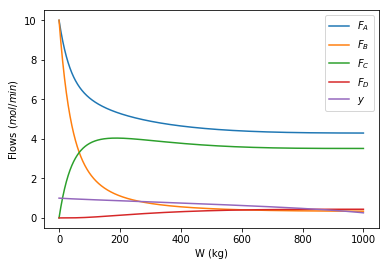

Simulating at 110 Celsius which is 383.15 Kelvin
Starting concentration = 0.1947801122275871 mol/dm3


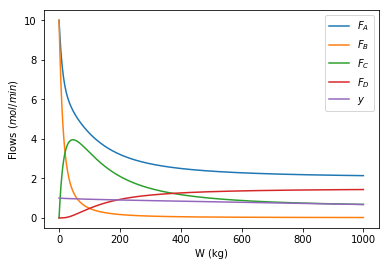

Simulating at 120 Celsius which is 393.15 Kelvin
Starting concentration = 0.18982576624697953 mol/dm3


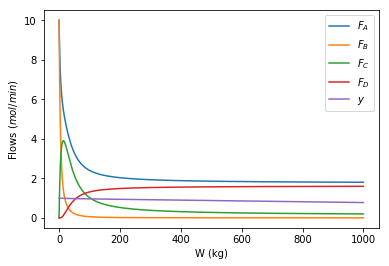

In [11]:
for temperature in [100, 110, 120]:
    integrate_plot_and_analyze(temperature)

## Part (b)
For a CSTR we have a set of nonlinear equations we must solve simultaneously. 
The simplest way is to do a mole balance, and create a set of differential equations 
for number of moles with respect to time, $d\mathbf{N}/dt$. At steady state 
we know $d\mathbf{N}/dt = 0$, so the differential equations become algebraic equations.

We'll set up $d\mathbf{N}/dt$ as a function of the exit concentrations $\mathbf{C}$ then use the `root` function from `scipy.optimize` to find the root of this equation  i.e. what values of $\mathbf{C}=[C_A, C_R, C_S]$ will give set the equation equal to zero ($d\mathbf{N}/dt=0$)?  Note:  this is $\bf{exactly}$ like using solver in Excel.  A plausible alternative would be to run a time-varying equation until it reaches steady state.

For each species $i$ the mole balance gives
\begin{align*}
\frac{dN_i}{dt} &= F_{i0} - F_i + r_i V\\
 &= C_{i0}v_0 - C_i v_0 + r_i V\\
 &= v_0(C_{i0} - C_i + r_i \tau )
\end{align*}


In [15]:
# setting up CSTR parameters and feed conditions
V = 2500 # L
v0 = 100 # L/min
tau = V/v0 # min

Ca0 = 2 # M
Cb0 = 2 # M
Cc0 = 0 # M
Cd0 = 0 # M

#  IMPORTANT:  k's just like before!!
k1A = 10 # M**2 / min
k2C = 15 # M**4 / min

k1 = k1A/1
k2 = k2C/3

# the following block is just like defining the individual residuals in solver...no need to square and add them here.  
# Here, we want all equations to = 0 and we allow "root" to figure out the best path to solution.
def dNvectordt(Cvector):
    """
    This is a differential equation for the number of moles
    of each species in the reactor, as function of time.
    At steady state it should equal zero.
    We must pass in the exit species concentrations in a vector.
    """
    Ca, Cb, Cc, Cd = Cvector 
    # compute the rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3

    # compute the rates of generation of all species
    ra = -1 * r1 - 2 * r2
    rb = -2 * r1 + 0 * r2
    rc = +1 * r1 - 3 * r2
    rd = +0 * r1 + 1 * r2
    
    # Differential equations for rates of change of moles...want these to equal zero!
    dNadt = v0 * ( Ca0 - Ca + ra * tau)
    dNbdt = v0 * ( Cb0 - Cb + rb * tau)
    dNcdt = v0 * ( Cc0 - Cc + rc * tau)
    dNddt = v0 * ( Cd0 - Cd + rd * tau)
    return [dNadt, dNbdt, dNcdt, dNddt]

guess = [Ca0/2, Ca0/2, Ca0/2, Ca0/2] # provide an initial guess
result = scipy.optimize.root(dNvectordt, guess)  # this is exactly like using Solver

Ca, Cb, Cc, Cd = result.x #unpack the vector of concentrations

# do some printing
print ("")
print ("For a CSTR with spacetime = {0} seconds".format(tau))
for (label, value) in [('A',Ca),('B', Cb),('C',Cc),('D',Cd)]:
    print ("The concentration of {0} is {1:.4} M".format(label,value))


For a CSTR with spacetime = 25.0 seconds
The concentration of A is 0.5327 M
The concentration of B is 0.0848 M
The concentration of C is 0.193 M
The concentration of D is 0.2549 M


## Part (c)
For a semi-BR things are very similar to the PBR example.  this will compare with Fogler example 8-7.



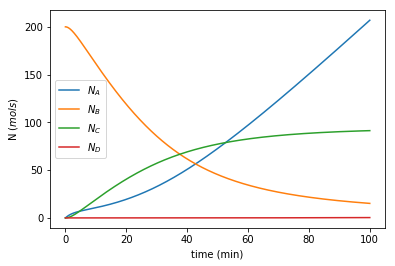

comparing to Fogler
206.892268079 15.1969996405 91.3421525685 0.353115870417 258.674730367

Maximum moles is 9e+01 mol/dm3
It occurs at about 100 +/- 0 minutes


In [11]:
# Inlet conditions, as this template is semi-PBR.  
# These would be "initial conditions" for BR/semiBR, where time varies instead.
V0 = 1000 #L initial volume
Cb0 = 0.2 # M, initial concentration of B (only one in the reactor)

vf = 10 #L/min, the feed rate for the semi-batch add
Caf = 0.3 # M---this is the concentration in the feed stream!

# Note only four species in this template...you'd need more or less depending on actual scenario.
Na0 = 0
Nb0 = V0 * Cb0 # note only B pre-loaded in this reactor
Nc0 = 0
Nd0 = 0

# REALLY IMPORTANT!!!  First copy k's referenced to species.
# Then: Convert k's from species reference to reaction number reference by dividing by stoichiometric coefficient.
k1A = 10 # L3/mol2/kgcat/min
k2C = 15 # L5/mol4/kgcat/min

k1 = k1A/1
k2 = k2C/3


# The function block that follows defines all the differential equation forms.
def dNvectordt(Nvector, time):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Na, Nb, Nc, Nd = Nvector # unpack values from vector into four flows and the y variable for PFR
    V = V0 + vf * time # compute volume

    # compute the concentrations that appear in rate expressions
    Ca = Na / V
    Cb = Nb / V
    Cc = Nc / V
    Cd = Nd / V

    # compute the rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3

    # compute the rates of generation of all species
    ra = -1 * r1 - 2 * r2
    rb = -2 * r1 + 0 * r2
    rc = +1 * r1 - 3 * r2
    rd = +0 * r1 + 1 * r2
    
    # Express the differential equations for rates of change of flows....
    # note you'd have additional terms for semi-BR or membrane PFR representing in/out flows
    dNadt = ra * V + vf * Caf
    dNbdt = rb * V
    dNcdt = rc * V
    dNddt = rd * V

    return [dNadt, dNbdt, dNcdt, dNddt] # pack up values into a vector.
    # "return" sends the info back to the ODE solver, many times

steps = np.linspace(0, 100, num=1001) # steps for ODE integration.  Here W begins at 0 and goes to 1000, with "num" steps.

Nvector0 = [Na0, Nb0, Nc0, Nd0] # initial values as specified way up above

Y_result = scipy.integrate.odeint(dNvectordt, Nvector0, steps) # BOOM!  the ODE integration happens here!
# Note:  errors from this statement generally due to some incompatibility, like the vectors not the same length.

# extract columns by transposing matrix and splitting into variables (the template has 4 flows and "y")
Na, Nb, Nc, Nd = Y_result.T 

# Do some plotting.  the plt.plot commands make the plots
plt.plot(steps, Na, label='$N_A$')
plt.plot(steps, Nb, label='$N_B$')
plt.plot(steps, Nc, label='$N_C$')
plt.plot(steps, Nd, label='$N_D$')
# the next three lines format the plots with legend and axis labels.
plt.legend(loc="best")
plt.xlabel('time (min)')
plt.ylabel('N ($mols$)')
plt.show()  # this displays the plot

print("comparing to Fogler")
print(Na[1000],Nb[1000],Nc[1000],Nd[1000],Nc[1000]/Nd[1000]) #checking versus Fogler
print("")
# this is just some code to locate a maximum and print some info
# first define the function for any array we call concentrations
# so that we can re-use it later
def report_maxN(concentrations, timesteps):
    max_R = concentrations.max()
    print ("Maximum moles is {0:.1g} mol/dm3".format(max_R))
    index = concentrations.argmax()
    max_time = timesteps[index]
    stepsize = timesteps[1]
    print ("It occurs at about {0:.0f} +/- {1:.0f} minutes".format(
                                                        max_time, stepsize))
# now call the function on the current Nc array
report_maxN(Nc, steps)

## Part (d)
Now that the semi-BR works we can convert it to a BR.



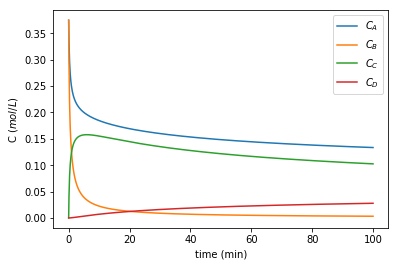

In [27]:
# These would be "initial conditions" for BR/semiBR, where time varies instead.
V0 = 2000 #L initial volume

# Note only four species in this template...you'd need more or less depending on actual scenario.
Ca0 = 0.375 # M, initial conc of A
Cb0 = 0.375 # M, initial concentration of B
Cc0 = 0
Cd0 = 0

# REALLY IMPORTANT!!!  First copy k's referenced to species.
# Then: Convert k's from species reference to reaction number reference by dividing by stoichiometric coefficient.
k1A = 10 # L3/mol2/kgcat/min
k2C = 15 # L5/mol4/kgcat/min

k1 = k1A/1
k2 = k2C/3


# NOTE:  adding this code just to illustrate use of exponential function np.exp and switching between reference and actual temp
Ea1 = 50 #kcal/mol
k1ref = k1
R_kcal = 0.00198720413 # kcal/mol/K
Tref = 410. + 273.15 #reference temperature in K--I've set this to be 410C like PS6Q4
T = 410 + 273.15 # actual temperature in K--for now, left it at 410C
k1 = k1ref * np.exp(-1*Ea1/R_kcal * (1./T - 1./Tref)) #Arrhenius computation of rate constant k1 at new temp



# The function block that follows defines all the differential equation forms.
def dCvectordt(Cvector, time):
    """
    Differential equation for flows as a function of weight of catalyst
    """
    Ca, Cb, Cc, Cd = Cvector # unpack values from vector into four flows and the y variable for PFR

    # compute the rates of reactions
    r1 = k1 * Ca * Cb**2
    r2 = k2 * Ca**2 * Cc**3

    # compute the rates of generation of all species
    ra = -1 * r1 - 2 * r2
    rb = -2 * r1 + 0 * r2
    rc = +1 * r1 - 3 * r2
    rd = +0 * r1 + 1 * r2
    
    # Express the differential equations for rates of change of flows....
    # note you'd have additional terms for semi-BR or membrane PFR representing in/out flows
    dCadt = ra
    dCbdt = rb
    dCcdt = rc
    dCddt = rd

    return [dCadt, dCbdt, dCcdt, dCddt] # pack up values into a vector.
    # "return" sends the info back to the ODE solver, many times

steps = np.linspace(0, 100, num=1001) # steps for ODE integration.  Here W begins at 0 and goes to 1000, with "num" steps.

Cvector0 = [Ca0, Cb0, Cc0, Cd0] # initial values as specified way up above

Y_result = scipy.integrate.odeint(dCvectordt, Cvector0, steps) # BOOM!  the ODE integration happens here!
# Note:  errors from this statement generally due to some incompatibility, like the vectors not the same length.

# extract columns by transposing matrix and splitting into variables (the template has 4 flows and "y")
Ca, Cb, Cc, Cd = Y_result.T

# Do some plotting.  the plt.plot commands make the plots
plt.plot(steps, Ca, label='$C_A$')
plt.plot(steps, Cb, label='$C_B$')
plt.plot(steps, Cc, label='$C_C$')
plt.plot(steps, Cd, label='$C_D$')
# the next three lines format the plots with legend and axis labels.
plt.legend(loc="best")
plt.xlabel('time (min)')
plt.ylabel('C ($mol/L$)')
plt.show()  # this displays the plot

#print("comparing to Fogler")
#print(Ca[1000],Cb[1000],Cc[1000],Cd[1000],Cc[1000]/Cd[1000]) #checking versus Fogler
#print("")
# this is just some code to locate a maximum and print some info
# first define the function for any array we call concentrations
# so that we can re-use it later
def report_maxC(concentrations, timesteps):
    max_R = concentrations.max()
    print ("Maximum concentration is {0:.3g} mol/dm3".format(max_R))
    index = concentrations.argmax()
    max_time = timesteps[index]
    stepsize = timesteps[1]
    print ("It occurs at about {0:.1f} +/- {1:.1f} minutes".format(
                                                        max_time, stepsize))
# now call the function on the current Cc array
#report_maxC(Cc, steps)  # for now we won't call that function!